# OpenVaccine: COVID-19 mRNA Vaccine Degradation Prediction

[kaggle competition site](https://www.kaggle.com/c/stanford-covid-vaccine) 

Dataset description:
- train set:                    2400 examples of length=107 and scoring_length=68
- public test set:              629  examples of length=107 and scoring_length=68
- private test set:             3005 examples of length=130 and scoring_length=91

### TODO:
- [X] no testing model, one model with different testing and training outputs
- [ ] augmentation
- [X] GCN
- [X] sequence fragmentation and similarieties finding

## Import section

In [15]:
%%time
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed, Concatenate, Lambda, Bidirectional, Dropout, RNN
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

import spektral
from spektral.layers import GraphConv, GraphAttention, GlobalAttentionPool

import seaborn as sns
import numpy as np
import pandas as pd

from data_preparation import *
from visualization import *
from custom_layers.subgraphing import Subgraphing
from custom_layers.custom_lstm_cell import CustomLSTMCell
from custom_layers.graph_lstm import GraphLSTM, GraphLSTMCell
from custom_layers.graph_reduce_cell import GraphReduceCell
from submissions.submit import *

import time
from datetime import datetime

import inspect
import json
import kerastuner as kt

CPU times: user 27.6 ms, sys: 3.88 ms, total: 31.5 ms
Wall time: 109 ms


In [2]:
%load_ext tensorboard

# Data Loading

In [3]:
# Dataset constants
STACKED_FEATURES_SIZE = 14
EDGES_FEATURES_MATRIX_DEPTH = 3
NEIGHBOURHOOD_SIZE = 30

In [4]:
%time raw_train_valid_ds, raw_public_test_ds, raw_private_test_ds = get_raw_datasets()

CPU times: user 2.5 s, sys: 707 ms, total: 3.2 s
Wall time: 3.22 s


In [5]:
# %time subgraphed_train_valid_ds, subgraphed_public_test_ds, subgraphed_private_test_ds = load_subgraphed_datasets(neighbourhood_size=NEIGHBOURHOOD_SIZE) 
%time subgraphed_train_valid_ds, subgraphed_public_test_ds, subgraphed_private_test_ds = load_base_datasets()

CPU times: user 416 ms, sys: 194 ms, total: 610 ms
Wall time: 649 ms


In [6]:
inspect_dataset_columns(subgraphed_train_valid_ds)

FEATURES:


,feature_name,tensor_shape
0,sequence,"(68, 4)"
1,structure,"(68, 3)"
2,predicted_loop_type,"(68, 7)"
3,adjacency_matrix,"(68, 68)"
4,edges_features_matrix,"(68, 68, 3)"
5,seq_scored,()
6,stacked_base_features,"(68, 14)"



LABELS:


,label_name,tensor_shape
0,stacked_scored_labels,"(68, 3)"


dataset cardinality: 2400


# Model

### Definition

In [ ]:
def create_model_for_subgraphed_dataset(neighbourhood_size, stacked_features_size, edges_features_matrix_depth):
    # Define inputs
    sequence = Input(shape=(None, 4), name='sequence')
    structure = Input(shape=(None, 3), name='structure')
    loop_type = Input(shape=(None, 7), name='predicted_loop_type')
    
    not_subgraphed_inputs = (sequence, structure, loop_type)
    
    subgraphed_stacked_base_features = Input(shape=(None, neighbourhood_size, stacked_features_size), name='stacked_base_features')
    subgraphed_adjacency_matrices = Input(shape=(None, neighbourhood_size, neighbourhood_size), name='adjacency_matrix')
    subgraphed_edges_features_matrices = Input(shape=(None, neighbourhood_size, neighbourhood_size, edges_features_matrix_depth), name='edges_features_matrix')

    subgraphed_inputs = (subgraphed_stacked_base_features, subgraphed_adjacency_matrices, subgraphed_edges_features_matrices)
    
    inputs = not_subgraphed_inputs + subgraphed_inputs
    
    # Main processing
    x = Concatenate()(not_subgraphed_inputs)
    seq = Bidirectional(LSTM(128, return_sequences=True))(x)
    embedded_subgraphs_seq = Bidirectional(RNN(GraphLSTMCell(256), return_sequences=True))(subgraphed_inputs)
    
    x = Concatenate()([seq, embedded_subgraphs_seq])
    
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    
    x = TimeDistributed(Dense(512, activation='relu'))(x)
    
    # Define outputs
    reactivity_pred = TimeDistributed(Dense(1), name='reactivity')(x)
    deg_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_Mg_pH10')(x)
    deg_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_Mg_50C')(x)

    scored_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred]
    outputs = Concatenate(axis=2, name='stacked_scored_labels')(scored_outputs)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [7]:
def create_model_for_subgraphed_dataset(neighbourhood_size, stacked_features_size, edges_features_matrix_depth):
    # Define inputs
    stacked_base_features = Input(shape=(None, stacked_features_size), name='stacked_base_features')
    adjacency_matrix = Input(shape=(None, None), name='adjacency_matrix')
    edges_features_matrix = Input(shape=(None, None, edges_features_matrix_depth), name='edges_features_matrix')

    inputs = (stacked_base_features, adjacency_matrix, edges_features_matrix)
    
    subgraphed_inputs = Subgraphing(40)(inputs)
    
    # Main processing
    seq = Bidirectional(LSTM(128, return_sequences=True))(stacked_base_features)
    embedded_subgraphs_seq = Bidirectional(RNN(GraphLSTMCell(256), return_sequences=True))(subgraphed_inputs)
    
    x = Concatenate()([seq, embedded_subgraphs_seq])
    
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    
    x = TimeDistributed(Dense(512, activation='relu'))(x)
    
    # Define outputs
    reactivity_pred = TimeDistributed(Dense(1), name='reactivity')(x)
    deg_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_Mg_pH10')(x)
    deg_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_Mg_50C')(x)

    scored_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred]
    outputs = Concatenate(axis=2, name='stacked_scored_labels')(scored_outputs)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

Submissions are scored using MCRMSE (mean columnwise root mean squared error):
$\textrm{MCRMSE} = \frac{1}{N_{t}}\sum_{j=1}^{N_{t}}\sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_{ij} - \hat{y}_{ij})^2}$

In [8]:
def mcrmse(y_true, y_pred):
    rmse = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))
    return tf.reduce_mean(rmse, axis=1)

### Instantiation

In [9]:
model = create_model_for_subgraphed_dataset(NEIGHBOURHOOD_SIZE, STACKED_FEATURES_SIZE, EDGES_FEATURES_MATRIX_DEPTH)

log_dir = os.path.join(os.getcwd(), 'logs')
model_name = datetime.now().strftime('model_%Y_%m_%d__%H_%M_%S')
model_log_dir = os.path.join(log_dir, model_name)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=0, update_freq='epoch')

model_file_name = model_name
models_path = os.path.join(os.getcwd(), 'models')
model_path = os.path.join(models_path, model_file_name)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, moniotr='val_loss', verbose=1, save_best_only=True, period=10)

model.compile(loss=mcrmse,
#               optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9),
              optimizer='adam')

In [10]:
model_path

'/home/jan/kaggle_competitions/covid/models/model_2020_10_05__13_27_06'

### Inspection

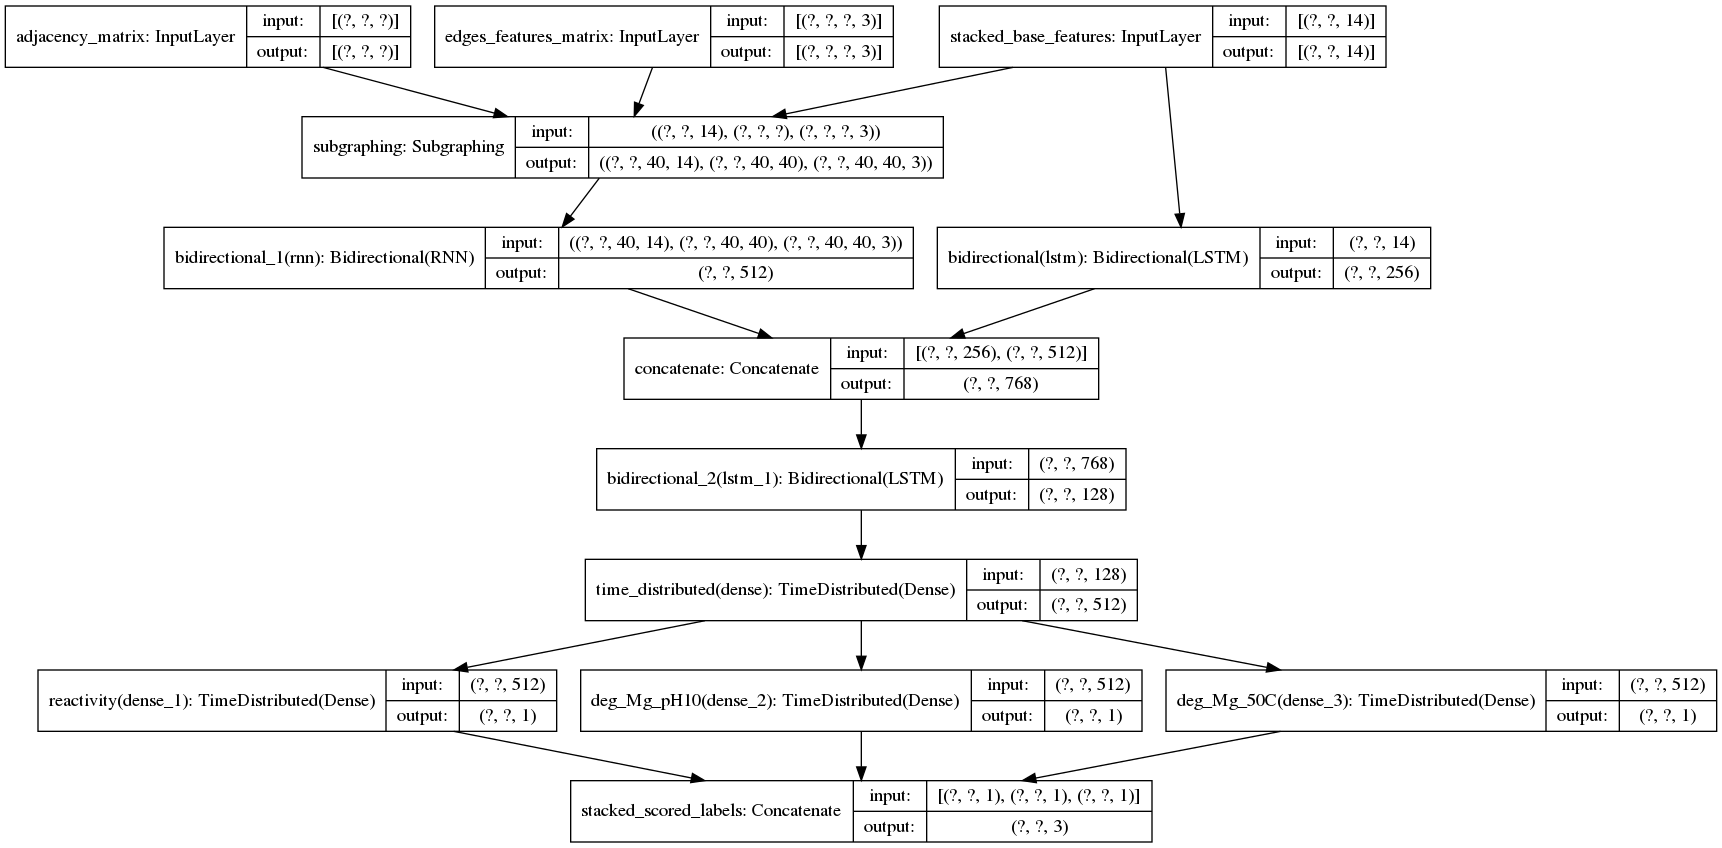

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [11]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
stacked_base_features (InputLay [(None, None, 14)]   0                                            
__________________________________________________________________________________________________
adjacency_matrix (InputLayer)   [(None, None, None)] 0                                            
__________________________________________________________________________________________________
edges_features_matrix (InputLay [(None, None, None,  0                                            
__________________________________________________________________________________________________
subgraphing (Subgraphing)       ((None, None, 40, 14 0           stacked_base_features[0][0]      
                                                                 adjacency_matrix[0][0]

model.evaluate(subgraphed_valid_ds.batch(64))# Additional dataset preparations

In [12]:
SPLIT_FACTOR = 0.3
subgraphed_train_ds, subgraphed_valid_ds = split_into_train_and_valid(subgraphed_train_valid_ds, split_factor=SPLIT_FACTOR)

### Baseline training and testing models evaluation

In [13]:
model.evaluate(subgraphed_valid_ds.batch(64))

/home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['sequence', 'structure', 'predicted_loop_type', 'seq_scored'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


12/12 [==============================] - 82s 7s/step - loss: 0.7418


0.7418102025985718

# Model training

In [13]:
%tensorboard --logdir $log_dir

Reusing TensorBoard on port 6006 (pid 8264), started 0:06:02 ago. (Use '!kill 8264' to kill it.)

In [14]:
BATCH_SIZE = 32
EPOCHS = 10
history = model.fit(subgraphed_train_ds.batch(BATCH_SIZE),
                    validation_data=subgraphed_valid_ds.batch(BATCH_SIZE),
                    epochs=EPOCHS,
                    initial_epoch=0,
                    verbose=1,
                    shuffle=True,
                    callbacks=[tensorboard_callback, model_checkpoint_callback])

Epoch 1/10


/home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['sequence', 'structure', 'predicted_loop_type', 'seq_scored'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


 1/53 [..............................] - ETA: 0s - loss: 0.6698WARNING:tensorflow:From /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
53/53 [==============================] - 347s 7s/step - loss: 0.5453 - val_loss: 0.5042
Epoch 2/10
53/53 [==============================] - 341s 6s/step - loss: 0.4865 - val_loss: 0.4628
Epoch 3/10
53/53 [==============================] - 337s 6s/step - loss: 0.4614 - val_loss: 0.4799
Epoch 4/10
53/53 [==============================] - 338s 6s/step - loss: 0.4421 - val_loss: 0.4362
Epoch 5/10
53/53 [==============================] - 341s 6s/step - loss: 0.4356 - val_loss: 0.4254
Epoch 6/10
 1/53 [..............................] - ETA: 0s - loss: 0.3142

KeyboardInterrupt: 

In [26]:
def model_builder(hp):
    # Define inputs
    stacked_base_features = Input(shape=(None, STACKED_FEATURES_SIZE), name='stacked_base_features')
    adjacency_matrix = Input(shape=(None, None), name='adjacency_matrix')
    edges_features_matrix = Input(shape=(None, None, EDGES_FEATURES_MATRIX_DEPTH), name='edges_features_matrix')

    inputs = (stacked_base_features, adjacency_matrix, edges_features_matrix)
    
    neighbourhood_size = hp.Int('neighbourhood_size', min_value = 5, max_value = 65, step = 5)
    subgraphed_inputs = Subgraphing(neighbourhood_size)(inputs)
    
    # Main processing
    hp_lstm_1_units = hp.Int('lstm_1_units', min_value = 32, max_value = 256, step = 32)
    seq = Bidirectional(LSTM(hp_lstm_1_units, return_sequences=True))(stacked_base_features)
    
    hp_graph_lstm_units = hp.Int('graph_lstm_units', min_value = 64, max_value = 512, step = 64)
    embedded_subgraphs_seq = Bidirectional(RNN(GraphLSTMCell(hp_graph_lstm_units), return_sequences=True))(subgraphed_inputs)
    
    x = Concatenate()([seq, embedded_subgraphs_seq])
    
    hp_lstm_2_units = hp.Int('lstm_2_units', min_value = 32, max_value = 256, step = 32)
    x = Bidirectional(LSTM(hp_lstm_2_units, return_sequences=True))(x)
    
    hp_dense_1_units = hp.Int('dense_1_units', min_value = 64, max_value = 512, step = 64)
    x = TimeDistributed(Dense(hp_dense_1_units, activation='relu'))(x)
    
    # Define outputs
    reactivity_pred = TimeDistributed(Dense(1), name='reactivity')(x)
    deg_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_Mg_pH10')(x)
    deg_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_Mg_50C')(x)

    scored_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred]
    outputs = Concatenate(axis=2, name='stacked_scored_labels')(scored_outputs)

    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss=mcrmse, optimizer='adam')
    
    return model

In [29]:
tuner_dir_path = os.path.join(os.getcwd(), 'tuner_dir')
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 10,
                     factor = 2,
                     directory = tuner_dir_path,
                     project_name = 'tuner_project_name')

INFO:tensorflow:Reloading Oracle from existing project /home/jan/kaggle_competitions/covid/tuner_dir/tuner_project_name/oracle.json
INFO:tensorflow:Reloading Tuner from /home/jan/kaggle_competitions/covid/tuner_dir/tuner_project_name/tuner0.json


In [30]:
tuner.search(subgraphed_train_ds.batch(BATCH_SIZE),
             validation_data=subgraphed_valid_ds.batch(BATCH_SIZE),
             epochs=10,
             verbose=1,
             shuffle=True)

53/53 [==============================] - ETA: 0s - loss: 0.800 - ETA: 4:26 - loss: 0.960 - ETA: 5:39 - loss: 0.871 - ETA: 6:18 - loss: 0.841 - ETA: 6:36 - loss: 0.801 - ETA: 6:44 - loss: 0.777 - ETA: 6:46 - loss: 0.742 - ETA: 6:45 - loss: 0.709 - ETA: 6:44 - loss: 0.699 - ETA: 6:39 - loss: 0.672 - ETA: 6:33 - loss: 0.655 - ETA: 6:26 - loss: 0.642 - ETA: 6:19 - loss: 0.639 - ETA: 6:11 - loss: 0.628 - ETA: 6:02 - loss: 0.616 - ETA: 5:54 - loss: 0.620 - ETA: 5:45 - loss: 0.618 - ETA: 5:36 - loss: 0.613 - ETA: 5:27 - loss: 0.616 - ETA: 5:19 - loss: 0.610 - ETA: 5:09 - loss: 0.612 - ETA: 5:00 - loss: 0.604 - ETA: 4:51 - loss: 0.607 - ETA: 4:42 - loss: 0.600 - ETA: 4:32 - loss: 0.596 - ETA: 4:23 - loss: 0.591 - ETA: 4:14 - loss: 0.586 - ETA: 4:04 - loss: 0.580 - ETA: 3:54 - loss: 0.579 - ETA: 3:45 - loss: 0.576 - ETA: 3:35 - loss: 0.575 - ETA: 3:26 - loss: 0.576 - ETA: 3:16 - loss: 0.578 - ETA: 3:06 - loss: 0.576 - ETA: 2:57 - loss: 0.575 - ETA: 2:47 - loss: 0.572 - ETA: 2:37 - loss: 0.570 -

Epoch 2/3
53/53 [==============================] - ETA: 0s - loss: 0.797 - ETA: 4:15 - loss: 1.225 - ETA: 5:35 - loss: 1.037 - ETA: 6:16 - loss: 0.959 - ETA: 6:40 - loss: 0.897 - ETA: 6:46 - loss: 0.856 - ETA: 6:47 - loss: 0.824 - ETA: 6:45 - loss: 0.803 - ETA: 6:41 - loss: 0.781 - ETA: 6:37 - loss: 0.760 - ETA: 6:32 - loss: 0.740 - ETA: 6:26 - loss: 0.722 - ETA: 6:18 - loss: 0.712 - ETA: 6:10 - loss: 0.704 - ETA: 6:02 - loss: 0.695 - ETA: 5:54 - loss: 0.684 - ETA: 5:46 - loss: 0.670 - ETA: 5:37 - loss: 0.657 - ETA: 5:28 - loss: 0.655 - ETA: 5:19 - loss: 0.646 - ETA: 5:10 - loss: 0.636 - ETA: 5:01 - loss: 0.636 - ETA: 4:52 - loss: 0.629 - ETA: 4:42 - loss: 0.626 - ETA: 4:33 - loss: 0.623 - ETA: 4:23 - loss: 0.619 - ETA: 4:14 - loss: 0.618 - ETA: 4:04 - loss: 0.611 - ETA: 3:55 - loss: 0.608 - ETA: 3:45 - loss: 0.605 - ETA: 3:35 - loss: 0.600 - ETA: 3:26 - loss: 0.594 - ETA: 3:16 - loss: 0.593 - ETA: 3:06 - loss: 0.592 - ETA: 2:56 - loss: 0.591 - ETA: 2:47 - loss: 0.587 - ETA: 2:37 - los

Epoch 1/3
53/53 [==============================] - ETA: 0s - loss: 0.757 - ETA: 1:08 - loss: 0.717 - ETA: 1:27 - loss: 0.657 - ETA: 1:37 - loss: 0.634 - ETA: 1:41 - loss: 0.600 - ETA: 1:44 - loss: 0.636 - ETA: 1:45 - loss: 0.630 - ETA: 1:44 - loss: 0.607 - ETA: 1:44 - loss: 0.596 - ETA: 1:43 - loss: 0.584 - ETA: 1:41 - loss: 0.596 - ETA: 1:38 - loss: 0.614 - ETA: 1:36 - loss: 0.608 - ETA: 1:34 - loss: 0.607 - ETA: 1:32 - loss: 0.598 - ETA: 1:30 - loss: 0.596 - ETA: 1:28 - loss: 0.599 - ETA: 1:26 - loss: 0.599 - ETA: 1:24 - loss: 0.588 - ETA: 1:22 - loss: 0.588 - ETA: 1:19 - loss: 0.585 - ETA: 1:17 - loss: 0.583 - ETA: 1:14 - loss: 0.577 - ETA: 1:12 - loss: 0.575 - ETA: 1:09 - loss: 0.572 - ETA: 1:07 - loss: 0.566 - ETA: 1:05 - loss: 0.564 - ETA: 1:02 - loss: 0.563 - ETA: 1:00 - loss: 0.561 - ETA: 57s - loss: 0.559 - ETA: 55s - loss: 0.55 - ETA: 52s - loss: 0.55 - ETA: 50s - loss: 0.54 - ETA: 47s - loss: 0.54 - ETA: 45s - loss: 0.54 - ETA: 42s - loss: 0.54 - ETA: 40s - loss: 0.54 - ETA:

Epoch 1/3
53/53 [==============================] - ETA: 0s - loss: 0.670 - ETA: 53s - loss: 0.75 - ETA: 1:08 - loss: 0.718 - ETA: 1:15 - loss: 0.693 - ETA: 1:18 - loss: 0.685 - ETA: 1:20 - loss: 0.666 - ETA: 1:21 - loss: 0.660 - ETA: 1:20 - loss: 0.652 - ETA: 1:20 - loss: 0.646 - ETA: 1:19 - loss: 0.638 - ETA: 1:18 - loss: 0.644 - ETA: 1:16 - loss: 0.648 - ETA: 1:15 - loss: 0.644 - ETA: 1:14 - loss: 0.632 - ETA: 1:12 - loss: 0.627 - ETA: 1:10 - loss: 0.625 - ETA: 1:09 - loss: 0.619 - ETA: 1:07 - loss: 0.609 - ETA: 1:05 - loss: 0.608 - ETA: 1:04 - loss: 0.605 - ETA: 1:02 - loss: 0.602 - ETA: 1:00 - loss: 0.598 - ETA: 58s - loss: 0.593 - ETA: 57s - loss: 0.59 - ETA: 55s - loss: 0.59 - ETA: 53s - loss: 0.58 - ETA: 51s - loss: 0.58 - ETA: 49s - loss: 0.58 - ETA: 47s - loss: 0.58 - ETA: 45s - loss: 0.58 - ETA: 43s - loss: 0.58 - ETA: 41s - loss: 0.58 - ETA: 39s - loss: 0.57 - ETA: 37s - loss: 0.57 - ETA: 35s - loss: 0.57 - ETA: 33s - loss: 0.56 - ETA: 32s - loss: 0.56 - ETA: 30s - loss: 0.5

INFO:tensorflow:Oracle triggered exit


### Training log

In [15]:
model_path

'/home/jan/kaggle_competitions/covid/models/model_2020_10_04__18_41_03'

In [16]:
def save_training_log(max_RAM, training_platform='PC', model_path=model_path, neighbourhood_size=NEIGHBOURHOOD_SIZE, split_factor=SPLIT_FACTOR, epochs=EPOCHS, batch_size=BATCH_SIZE, train_loss=None, valid_loss=None, train_ds=None, valid_ds=None):
    json_dict = {
        "training_platform": "PC",
        "max_RAM": max_RAM,
        "model_path": model_path,
        "neighbourhood_size": neighbourhood_size,
        "model_architecture": inspect.getsource(create_model_for_subgraphed_dataset),
        "split_factor": split_factor,
        "epochs": epochs,
        "batch_size": batch_size
    }

    if train_ds is not None:
        json_dict['train_loss'] = model.evaluate(train_ds.batch(4096), verbose=0)
    else:
        json_dict['train_loss'] = train_loss
      
    
    if valid_ds is not None:
        json_dict['valid_loss'] = model.evaluate(valid_ds.batch(4096), verbose=0)
    else:
        json_dict['valid_loss'] = valid_loss
    
    with open(model_path + '_training_log.json', 'w') as fp:
        json.dump(json_dict, fp)

In [20]:
save_training_log(14, train_ds=subgraphed_train_ds, valid_ds=subgraphed_valid_ds, epochs=900)

In [44]:
p = model.predict(subgraphed_valid_ds.batch(4096))

# Create submission

In [17]:
%time submission = create_submission(model, [subgraphed_public_test_ds, subgraphed_private_test_ds], [raw_public_test_ds, raw_private_test_ds])
submission

CPU times: user 12.6 s, sys: 2.96 s, total: 15.6 s
Wall time: 17.2 s


,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,-0.040086,0.031532,0.0,0.062259,0.0
1,id_00073f8be_1,-0.032577,0.038012,0.0,0.074928,0.0
2,id_00073f8be_2,-0.023177,0.036372,0.0,0.081184,0.0
3,id_00073f8be_3,-0.017458,0.035141,0.0,0.083916,0.0
4,id_00073f8be_4,-0.016983,0.034016,0.0,0.083959,0.0
...,...,...,...,...,...,...
457948,id_ffda94f24_125,0.000000,0.000000,0.0,0.000000,0.0
457949,id_ffda94f24_126,0.000000,0.000000,0.0,0.000000,0.0
457950,id_ffda94f24_127,0.000000,0.000000,0.0,0.000000,0.0
457951,id_ffda94f24_128,0.000000,0.000000,0.0,0.000000,0.0


In [19]:
submission_name = 'submission.csv'
submissions_dir = os.path.join(os.getcwd(), 'submissions')
submission_path = os.path.join(submissions_dir, submission_name)
submission.to_csv(submission_path, header=True, index=False)

# Model saving and loading

In [13]:
model_file_name = 'model_2020_10_04__18_41_03'

log_dir = os.path.join(os.getcwd(), 'logs')
model_log_dir = os.path.join(log_dir, model_file_name)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=0, update_freq='epoch')

models_path = os.path.join(os.getcwd(), 'models')
model_path = os.path.join(models_path, model_file_name)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, moniotr='val_loss', verbose=1, save_best_only=True)

In [14]:
model_path

'/home/jan/kaggle_competitions/covid/models/model_2020_10_04__18_41_03'

In [15]:
loaded_model = tf.keras.models.load_model(model_path, custom_objects={'mcrmse': mcrmse, 'GraphLSTMCell': GraphLSTMCell})

In [16]:
loaded_model.evaluate(subgraphed_valid_ds.batch(4096))
# model.evaluate(subgraphed_valid_ds.batch(4096))

/home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['seq_scored'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


1/1 [==============================] - 0s 985us/step - loss: 0.1649


0.1648821234703064

In [30]:
model = loaded_model

In [77]:
model.save(model_path)

INFO:tensorflow:Assets written to: /home/jan/kaggle_competitions/covid/models/model_2020_10_04__18_41_03/assets


In [79]:
model_file_name = 'model_2020_10_04__14_42_56'
models_path = os.path.join(os.getcwd(), 'models')
model_path = os.path.join(models_path, model_file_name)
loaded_model = tf.keras.models.load_model(model_path, custom_objects={'mcrmse': mcrmse, 'GraphLSTMCell': GraphLSTMCell})

TODO:
* cross-validation - more data to train
* signal_to_noise parameter - maybe it can be used in some way
* unsupervised pretraining